<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 4: ARIMA</h2></center>
<br>

This tutorial we add the ARIMA model to our analysis of the Australian inflation data from a previous tutorial. 

<a class="buttom" href=">#Data:-Australian-CPI-Inflation">Data: Australian CPI inflation</a><br>
<a class="buttom" href="#ARIMA-model-identification">ARIMA model identification</a><br>
<a class="buttom" href="#Estimation">Estimation</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook relies on the following imports and settings.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

##Data: Australian CPI inflation


In [3]:
data=pd.read_csv('datasets/inflation.csv', index_col='Date', parse_dates=True, dayfirst=True)
data.index=data.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
data=data['01-1980':] # filtering the use data from Jan/1980 onwards
data.tail()

,Inflation
Date,
2017Q3,0.6
2017Q4,0.6
2018Q1,0.4
2018Q2,0.4
2018Q3,0.4


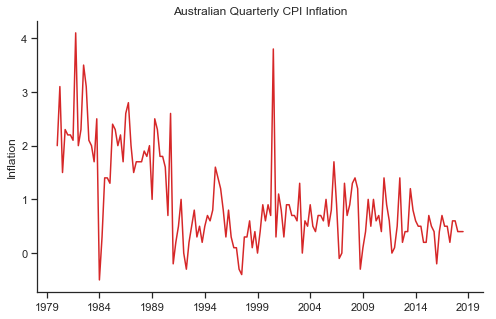

In [4]:
y=data['Inflation']

fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

##ARIMA model identification

The next cell plots the sample autocorrelations (ACF) and partial autocorrelations (PACF) for the entire series. The autocorrelations decay slowly, reflecting the non-stationarity of the series. 

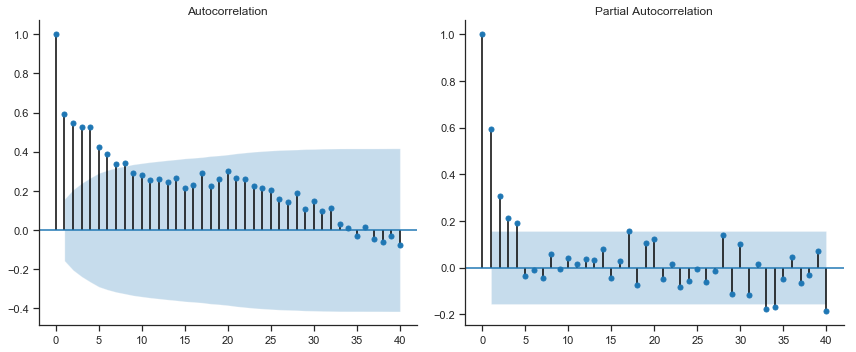

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

We then consider a first difference transform, which seems to lead to a stationary series for this data. The pandas [shift](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) method is the tool for obtaining lagged values of a column. 

The ACF plot for the first difference series has a cut-off after lag one, while the PACF shows a gradual decrease, suggesting a MA(1) for the data. 

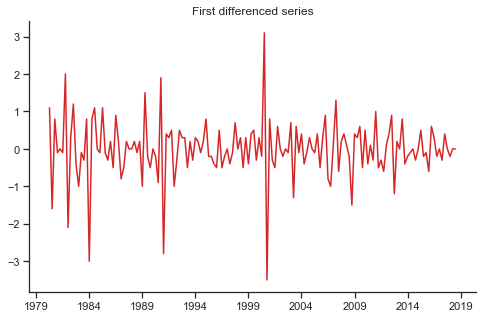

In [6]:
diff=y-y.shift(1)
diff=diff.dropna()

fig, ax= plt.subplots(figsize=(8,5))
diff.plot(color=red)
ax.set_xlabel('')
ax.set_title('First differenced series')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

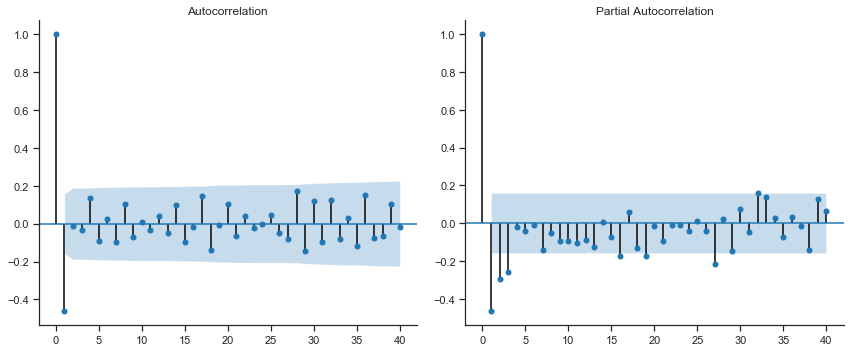

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

In the EDA, we saw that the series behaves differently in the post-80s period, so that we can also consider focusing on this part of the dataset only. The need for first differencing is less clear in this case, so that we will consider specifications with and without the transformation

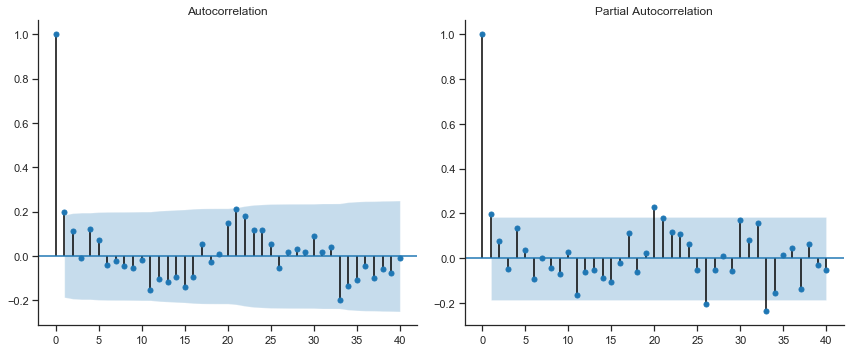

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y['1991':], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(y['1991':], lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

With the first difference, the ACF and PACF are again consistent with an MA(1) process. 

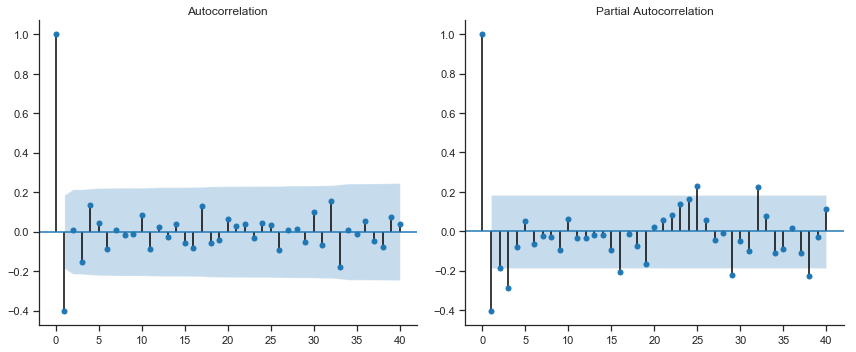

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(diff['1991':], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff['1991':], lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

###Estimation

We now estimate the ARIMA(0,1,1) model for the full data using the <TT>statsmodels</TT> package.

In [10]:
arima1 = sm.tsa.ARIMA(y, order=(0, 1, 1)).fit(trend='nc') # trend='nc' option estimates a model without a drift
print(arima1.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Inflation   No. Observations:                  154
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -150.667
Method:                       css-mle   S.D. of innovations              0.642
Date:                Mon, 19 Nov 2018   AIC                            305.334
Time:                        19:31:46   BIC                            311.408
Sample:                    06-30-1980   HQIC                           307.801
                         - 09-30-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1.D.Inflation    -0.7098      0.071    -10.027      0.000      -0.849      -0.571
                                    Roots                                    
                  Real          

Restricting attention to the data since 1991, we consider two specifications: ARIMA(1,0,1) and ARIMA(0,1,1). Note that for the ARIMA(1,0,1) estimation, I remove the first observation to make it comparable to the ARIMA(0,1,1) output (which loses the first observation due to first differencing). 

The AIC and BIC criteria select the ARIMA(0,1,1) specification. Using only the 1991-2016 period substantially changes the estimate of the MA(1) coefficient. 

In [11]:
arima2 = sm.tsa.ARIMA(y['1991':].iloc[1:], order=(1, 0, 1))  .fit(trend='nc')
print(arima2.summary())

                              ARMA Model Results                              
Dep. Variable:              Inflation   No. Observations:                  110
Model:                     ARMA(1, 1)   Log Likelihood                 -86.278
Method:                       css-mle   S.D. of innovations              0.525
Date:                Mon, 19 Nov 2018   AIC                            178.556
Time:                        19:31:46   BIC                            186.658
Sample:                    06-30-1991   HQIC                           181.842
                         - 09-30-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.Inflation     0.9969      0.007    142.403      0.000       0.983       1.011
ma.L1.Inflation    -0.9218      0.073    -12.601      0.000      -1.065      -0.778
                                

In [12]:
arima3 = sm.tsa.ARIMA(y['1991':], order=(0, 1, 1)).fit(trend='nc')
print(arima3.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Inflation   No. Observations:                  110
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -86.729
Method:                       css-mle   S.D. of innovations              0.528
Date:                Mon, 19 Nov 2018   AIC                            177.457
Time:                        19:31:46   BIC                            182.858
Sample:                    06-30-1991   HQIC                           179.648
                         - 09-30-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1.D.Inflation    -0.9209      0.071    -13.029      0.000      -1.059      -0.782
                                    Roots                                    
                  Real          

###Model diagnostics

To obtain the residual series:

In [13]:
resid=arima3.resid

As diagnostics, we plot the residual series, the ACF and PACF plots, and the histogram of the residual data. We find no autocorrelation patterns in the residuals, confirming that the ARIMA(0,1,1) adequately captures the time series dependence in the series. The histogram shows that the residual series is non-Gaussian, so that we should not rely on this assumption for building forecast intervals. 

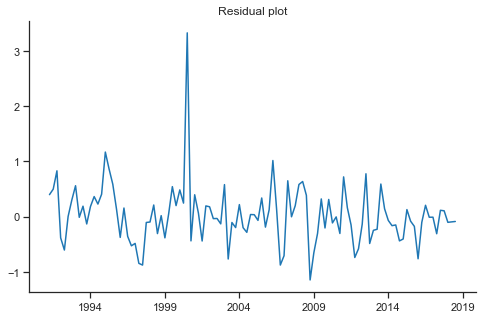

In [14]:
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

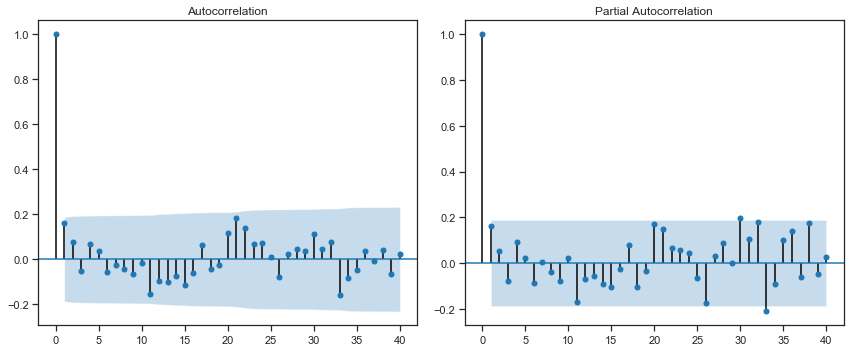

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

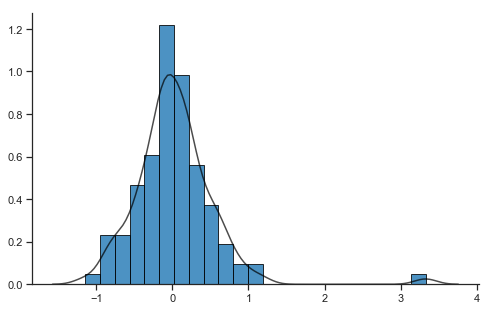

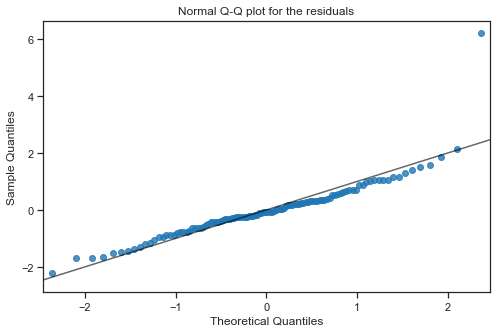

In [16]:
from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

##Model validation

We implement a real time forecasting exercise to select the best model for the final forecast. 

In [17]:
import forecast

# Real time forecasting 

validation=y['2004Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2004Q1') # numerical index corresponding to Q1 2004
recent = y.index.get_loc('2000Q1')

results=pd.DataFrame(0.0, index=validation, columns=['RW', 'SES', 'Trend corrected', 
                                                               'ARIMA', 'ARIMA (1991-)','Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
    
    # random walk forecast
    results.iloc[j,0]=y.iloc[i-1] 
    
    # simple exponential smoothing
    model = forecast.ses(y.iloc[:i]) 
    model.fit()
    results.iloc[j,1]= model.forecast(1)[0]
    
    # trend corrrected
    model = forecast.holt(y.iloc[:i])
    model.fit()
    results.iloc[j,2]=model.forecast(1)[0] 
    
    # ARIMA 
    model = sm.tsa.ARIMA(y.iloc[:i], order=(0, 1, 1)).fit()  
    results.iloc[j,3]=model.forecast()[0][0]
    
    # ARIMA (recent sample)
    model = sm.tsa.ARIMA(y.iloc[recent:i], order=(0, 1, 1)).fit()  
    results.iloc[j,4]= model.forecast()[0][0]

In [18]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(5):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
RW,0.518,0.056
SES,0.478,0.053
Trend corrected,0.478,0.053
ARIMA,0.449,0.053
ARIMA (1991-),0.448,0.045


##Forecast

We compute the final forecast using the ARIMA(0,1,1) model estimated on the full sample. 

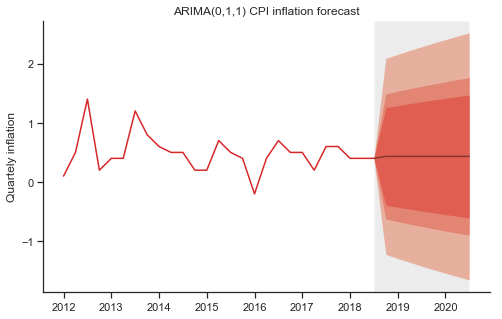

In [19]:
h=8 

pred, stderr, intv1 = arima1.forecast(steps=h, alpha=0.2)
pred, stderr, intv2 = arima1.forecast(steps=h, alpha=0.1)
pred, stderr, intv3 = arima1.forecast(steps=h, alpha=0.01)

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')

pred=pd.Series(pred, index=test)

intv1=pd.DataFrame(intv1, index=test)
intv2=pd.DataFrame(intv2, index=test)
intv3=pd.DataFrame(intv3, index=test)


fig, ax = forecast.fanchart(y['2012':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Quartely inflation')
sns.despine()
plt.title('ARIMA(0,1,1) CPI inflation forecast')

plt.show()